In [32]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import cv2
import motion_detector as md
import os
import urllib
import datetime
import re
import time
import detect_train as dt
import matplotlib as mpl
mpl_update = {'font.size':16,'xtick.labelsize':14,'ytick.labelsize':14,'figure.figsize':[12.0,8.0],'axes.color_cycle':['#0055A7', '#2C3E4F', '#26C5ED', '#00cc66', '#D34100', '#FF9700', 
                                 '#091D32'], 'axes.labelsize':20,'axes.labelcolor':'#677385','axes.titlesize':20,'lines.color':'#0055A7','lines.linewidth':3,'text.color':'#677385'}
mpl.rcParams.update(mpl_update)
from IPython import display

In [2]:
%load_ext autoreload
%autoreload 2

# Trainspotting

In this demo, I will walk you through how we created an algorithm using image processing techniques and heuristics unique to the our problem that detects whether a train is passing our office and what direction it is going in. 

# Load video

In [3]:
avi_file = md.load_avi('test.avi')

In [51]:
for j,frame in enumerate(avi_file):
    cv2.imshow('Original video',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
cv2.destroyWindow('Original video')

# Convert to gray scale

We like to see video in color.  However, motion detection typically only requires one channel (i.e. gray-scale) images. Numerous methods exist for converting to one-channel or gray-scale including simply choosing one of the three color channels, using weighted combinations of the blue, green, and red channels as well as using the first component from a [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA). We will use OpenCV's gray scale function, which uses a weighted combination of the three channels.

In [52]:
for j,frame in enumerate(avi_file):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imshow('Gray scale',gray_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
cv2.destroyWindow('Gray scale')

# Smooth the frame

Our goal is to detect differences between frames (i.e. motion) but we don't want to detect any differences due to noise or small scale changes (such as leaves rustling). Therefore, we smooth each frame after we convert it to one channel using a [Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur). The provided parameter, g,  is the size of the kernel used to smooth the image. In practice, you will want to tweak these values after the motion detection is working to meet the needs of your camera and the scale of objects you are trying to detect. 

In [10]:
g=31

In [53]:
for j,frame in enumerate(avi_file):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    smooth_frame = cv2.GaussianBlur(gray_frame, (g, g), 0)
    cv2.imshow('Smooth', smooth_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
cv2.destroyWindow('Smooth')

# Running average

If motion occurs, the image changes. Therefore detecting motion requires detecting differences between the current frame and what has been seen previously. To reduce sensitivity to small-scale motion, we want to use a running average of the previous frames to compare to our current frame. In OpenCV, the running average function relies on a parameter, `alpha`, which adjusts how many of the previous frames are used in the average and how heavily they are weighted. 

In [9]:
alpha=0.2

In [54]:
running_avg = None
for j,frame in enumerate(avi_file):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    smooth_frame = cv2.GaussianBlur(gray_frame, (31, 31), 0)
    if running_avg is None:
        running_avg = np.float32(smooth_frame)
    else:
        cv2.accumulateWeighted(np.float32(smooth_frame), running_avg,
                               alpha)
    cv2.imshow('Running average', cv2.convertScaleAbs(running_avg))
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
cv2.destroyWindow('Running average')

# Detect change

To detect change, we take the difference between the running average frame and the current frame. 

For simplification, I will replace steps with their corresponding functions in `motion_detector.py`. In the following code block, we are using `md.get_running_avg()` to get `smooth_frame` and `running_avg`.

In [4]:
running_avg = None
for j,frame in enumerate(avi_file):
    smooth_frame, running_avg = md.get_running_avg(frame, running_avg, alpha=0.2)
    diff = cv2.absdiff(np.float32(smooth_frame), np.float32(running_avg))
    cv2.imshow('Difference', diff)
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
cv2.destroyWindow('Difference')

# Threshold the difference

Next, we want to consider pixels where change occurs past a given threshold. The following code sets all pixels where the current frame is more than 25 value points different from the running average as being in motion and all other pixels as being still. 

In [8]:
thresh = 25

In [7]:
thresh_diff_all = []
running_avg = None
for j,frame in enumerate(avi_file):
    smooth_frame, running_avg = md.get_running_avg(frame, running_avg, alpha=0.2)
    diff = cv2.absdiff(np.float32(smooth_frame), np.float32(running_avg))
    _, thresh_diff = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY_INV)
    cv2.imshow('Thresh-holded difference', thresh_diff)
    thresh_diff_all.append(thresh_diff)
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
cv2.destroyWindow('Thresh-holded difference')

# Subtract right from left side

Typical motion detection algorithms would next identify the edges of entities that are moving from the threshold image, find the centroids of the polygons that the edges create, and track those centroids. However, in this case, the non-window sections of the train don't change in pixel value significantly, making the only movement that is tracked that of the windows. There are so many windows passing by that it is difficult to track single windows entirely across the frame to detect direction of movement. 

Improvements to make traditional motion detection work would probably have required a higher resolution camera or extensive fine tuning and improvement of the image processing algorithms. Instead, we decided to take advantage of the unique characteristics of our specific problem. 

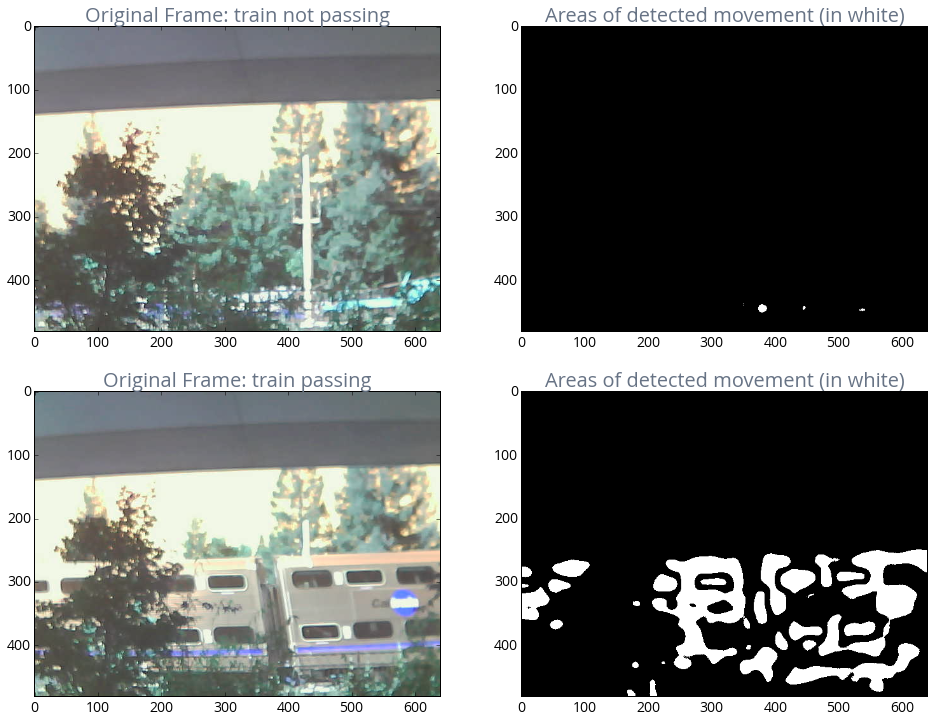

In [14]:
plt.subplots(2,2,figsize=(16,12));
plt.subplot(221);
plt.imshow(avi_file[5]);
plt.title('Original Frame: train not passing');
plt.subplot(222);
plt.imshow(thresh_diff_all[5], cmap='Greys');
plt.title('Areas of detected movement (in white)');
plt.subplot(223);
plt.imshow(avi_file[100]);
plt.title('Original Frame: train passing');
plt.subplot(224);
plt.imshow(thresh_diff_all[100], cmap='Greys');
plt.title('Areas of detected movement (in white)');

As you see in the left hand images above, there is a tree that partially obstructs the view of the train. While this obstruction may have initially been seen as less than ideal, we realized that the tree causes an area of the frame to almost always remain motionfree (according to our chosen threshold). 

When no train is passing, almost no movement is detected across the entire frame and the thresholded difference is more or less equal on the right and left sides. However, when a train is passing, the tree still remains motionless in front of the left hand side of the train, creating an asymmetry in the thresholded difference between the current frame and running average (see lower right corner above). 

We can then detect when a train is passing because the difference in the sum of the pixels on the left (`left_sum`) and right halves (`right_sum`) of the frame exceeds a threshold value. Moreover, when the train is only present in the left side of the image, `right_sum - left_sum` is largely negative. 

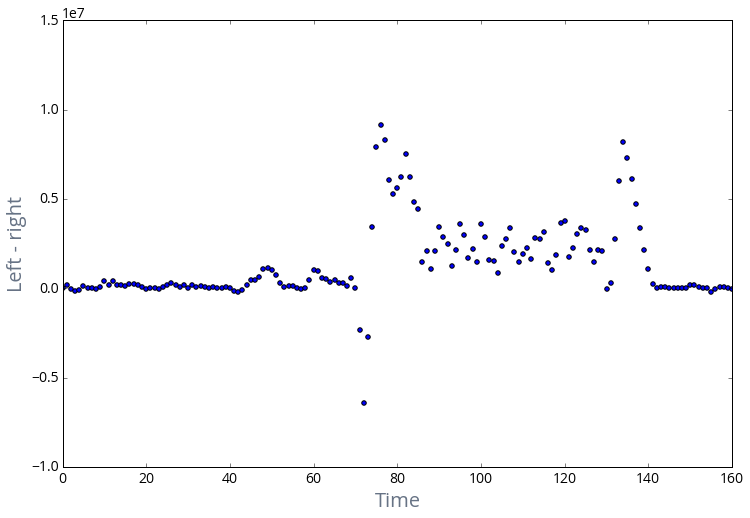

In [15]:
from IPython import display
fig, ax = plt.subplots()
plt.xlim([0,160]);
plt.ylim([-1e7,1.5e7]);
plt.xlabel('Time');
plt.ylabel('Left - right ')
running_avg = None
for j,frame in enumerate(avi_file):
    smooth_frame, running_avg = md.get_running_avg(frame, running_avg, alpha=alpha)
    diff, thresh_diff = md.get_diff(smooth_frame, running_avg, thresh=thresh)
    left_sum = sum(sum(thresh_diff[:, :320]))
    right_sum = sum(sum(thresh_diff[:, 320:]))
    left_minus_right = left_sum-right_sum
    cv2.imshow('Thresh-holded difference', thresh_diff)
    plt.scatter(j,left_minus_right)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
cv2.destroyWindow('Thresh-holded difference')
plt.close()

When you run the above code, you see that `right_sum - left_sum` remains close to zero until the train passes. As the train approaches from the left, `right_sum - left_sum << 0`. Once the train fills the entire frame, `right_sum - left_sum >> 0` because more of the right hand side of the frame is in motion than the left. 

Therefore, we can create logic that detects a train when `right_sum - left_sum > upper_thresh` and detects a train only on the left hand side of the frame when `right_sum - left_sum < lower_thresh`. By training the model on multiple clips of trains passing, we can fit the best `upper_thresh` and `lower_thresh`. In this demo, we assume we already fit these thresholds.

In [5]:
lower_thresh=-400000
upper_thresh=1000000

# Detect train

In [4]:
running_avg = None
for j,frame in enumerate(avi_file):
    smooth_frame, running_avg = md.get_running_avg(frame, running_avg, alpha=alpha, g=g)
    diff, thresh_diff = md.get_diff(smooth_frame, running_avg, thresh=thresh)
    left_sum, right_sum  = sum(sum(thresh_diff[:, :320])), sum(sum(thresh_diff[:, 320:]))
    left_minus_right = left_sum - right_sum
    cv2.imshow('Thresh-holded difference', thresh_diff)
    if left_minus_right < lower_thresh:
        there = 'left'
    elif left_minus_right > upper_thresh:
        there = 'train'
    else:
        there = 'none'
    if there != 'none':
        print there
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
cv2.destroyWindow('Thresh-holded difference')
plt.close()

left
left
left
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train


# Detect direction

The difference between the left and right sides of the thresholded image really just tells us that something the size of a train is moving in the frame or on the left side of the frame. To detect that it in actual fact is a Caltrain and not a UPS truck (or other moving vehicle), we have to consider the classification across a series of frames. 

To detect whether an actual Caltrain is passing, we require a train to be detected a minimum number of frames, `min_count`. Once `min_count` has been reached, we then look at the first frame to see if we classified the train as entering on the left side of the frame. If the first frame of the train was classified as "left", then the train is south-bound. If the first frame was not classified as "left", it must be moving north-bound.

In the next frame, I employ this logic, which requires the fitting of the parameter `min_count`, which will change if the frame rate of the video camera changes (i.e. if the number of frames per second recorded increases or decreases). I run the train detection code for the video clip run forward and then backward to show the change in direction detected. 

In [ ]:
min_count=45

In [13]:
train_count = []
train_pass = []
train = None
running_avg = None
for j,frame in enumerate(avi_file + avi_file[::-1]):
    
    
    smooth_frame, running_avg = md.get_running_avg(frame, running_avg, alpha=0.2, g=31)
    diff, thresh_diff = md.get_diff(smooth_frame, running_avg, thresh=25)
    there, left_minus_right= md.left_minus_right(thresh_diff, upper_thresh=upper_thresh, lower_thresh=lower_thresh)
    
    cv2.imshow('Original video', frame)
    
    
    # Add to current train or assess if train has passed
    if there != 'none':
        train_count.append(there)
    elif len(train_count) == 0:
        train_count = []
    elif len(train_count) < min_count:
        if train_count[-1] == 'none':
            train_count = []
    elif len(train_count) > min_count:
        if train_count[0] == 'left':
            train = (j, 'south')
            train_count = []
        else:
            train = (j, 'north')
            train_count = []
    else:
        train_count.append(there)
    
    # Add newly detected train to list
    if train is not None:
        train_pass.append(train)
        print train
        train = None
    
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
cv2.destroyWindow('Original video')
plt.close()

(138, 'south')
(258, 'north')


# Bringing it all together

The end product is a model for detecting the train given a set of frames. In practice, we must train the model on labeled training data to estimate values for the following parameters:
* `alpha`: adjusts how much the previous frames are weighted in the `running_avg`. Will change according to frame rate of camera.
* `g`: gives the size of the kernel used to perform the Gaussian blur for smoothing the image. Will change according to the resolution and quality of the image. 
* `thresh`: is the cut-off for the value of the difference between a pixel in the current frame and moving average to be considered moving. 
* `lower_thresh, upper_thresh`: upper and lower limits for considering a train moving througout the whole frame and the left hadn side of the frame. 
* `min_count`: Number of frames train has to be detected in for it to be considered a Caltrain. Depends on frame rate and length of train to be detected. 

The end function should be iterable if more frames are added in the future. Therefore, the outputs can be used as inputs the same function. 

In [34]:
def train_detector(frames, running_avg=None, train_count=None, 
                 train_pass=None, play=True, alpha=0.2, 
                 g=31, thresh=25, lower_thresh=-400000, 
                 upper_thresh=1000000, times=None):
    
    if train_count is None:
        train_count = []
    if train_pass is None:
        train_pass = []
    if times is None:
        times = range(len(frames))
    for j,frame in enumerate(frames):
        smooth_frame, running_avg = md.get_running_avg(frame, running_avg, alpha=alpha, g=g)
        diff, thresh_diff = md.get_diff(smooth_frame, running_avg, thresh=thresh)
        there, left_minus_right= md.left_minus_right(thresh_diff, upper_thresh=upper_thresh, lower_thresh=lower_thresh)
        train, train_count = md.detect_train(train_count, there, times[j], min_count=min_count)
        if play:
            cv2.imshow('Original video', frame)

        # Add newly detected train to list
        if train is not None:
            train_pass.append(train)
            train = None

        if cv2.waitKey(1) & 0xFF == ord('q'): 
            break
    if play:        
        cv2.destroyWindow('Original video')
    return train_pass, train_count, running_avg

## Run function on the video clip. 

In [35]:
train_pass, train_count, running_avg = train_detector(avi_file)
train_pass

[(138, 'south')]

## Add more frames

In [28]:
train_pass, train_count, running_avg = train_detector(avi_file[::-1], running_avg, train_count, train_pass, times=range(len(avi_file),len(avi_file)*2+1))
train_pass

[(138, 'south'), (258, 'north')]

# From `motion_detector.py`

In [41]:
train_pass, train_count, running_avg = md.train_detector(avi_file+avi_file[::-1])
train_pass

[(138, 'south'), (258, 'north')]

# Trying out motion detection at home

You can try out the motion detection algorithms shown here using your own web cam! Use the following code to start. Simply press 'q' on your keyboard to end the demo.  

In [42]:
feed = cv2.VideoCapture(0)
running_avg = None
while True:
    frame = md.get_frame_cam(feed)
    smooth, running_avg = md.get_running_avg(frame, running_avg, alpha=0.02)
    diff, thresh_diff = md.get_diff(smooth, running_avg, thresh=95)
    edges, contours = md.get_edges_contours(thresh_diff)
    c_x,c_y, areas, circle_frame = md.get_centroids(contours, frame=frame)
    cv2.imshow('Frame - running average', edges)
    cv2.imshow('Threshold of frame - running average', thresh_diff)
    cv2.imshow('Edges', edges)
    cv2.imshow('Frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
feed.release()
cv2.destroyAllWindows()